In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from time import time
from joblib import Parallel, delayed
from scipy.stats.mstats import gmean
from bayes_opt import BayesianOptimization
from triqler.qvality import getQvaluesFromScores

from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = 'Arial'

In [2]:
evidence = pd.read_csv('../data/SampleSet/evidence.txt', sep='\t', low_memory=False)
evidence.shape

(208618, 112)

# SampleRT

In [3]:
from DeepSCP import MQ_SampleRT

In [4]:
%%time
# sampleRT = MQ_SampleRT(r=3, filter_PEP=False)
sampleRT = MQ_SampleRT()
dfRT = sampleRT.fit_tranform(evidence)
SampleRT_scores = sampleRT.cmp_scores

Wall time: 10.5 s


In [5]:
SampleRT_scores.to_csv('../data/SampleRT_scores.csv', index=False)

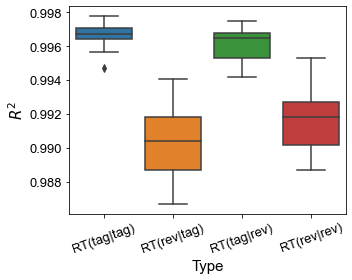

In [6]:
plt.figure(figsize=(5, 4))
# SampleRT_scores = pd.read_csv('../input/SampleRT_scores.csv')
SampleRT_scores = SampleRT_scores[SampleRT_scores['score'] > 0]

sns.boxplot(y='score', x='type', data = SampleRT_scores)
plt.xticks(fontsize=13, rotation=20)
plt.yticks(fontsize=13)

plt.xlabel('Type', fontsize=15)
plt.ylabel('$R^2$', fontsize=15)
plt.tight_layout()
plt.savefig('../figure/SampleRT.pdf')

In [7]:
SampleRT_scores.groupby('type')['score'].median()

type
RT(rev|rev)    0.991829
RT(rev|tag)    0.990413
RT(tag|rev)    0.996486
RT(tag|tag)    0.996702
Name: score, dtype: float64

# DeepSpec

In [8]:
from DeepSCP import DeepSpec

In [9]:
lbmsms = pd.read_csv('../data/LibrarySet/msms.txt', sep='\t', low_memory=False)
lbmsms.shape

(47905, 111)

In [10]:
msms = pd.read_csv('../data/SampleSet/msms.txt', sep='\t', low_memory=False)
msms.shape

(213502, 111)

In [11]:
%%time
# deepspec = DeepSpec(model=None, seed=0, test_size=0.2, lr=1e-3, l2=0.0,
#                     batch_size=1024, epochs=1000, nepoch=50, patience=50,
#                     device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
deepspec = DeepSpec()
deepspec.fit(lbmsms)

+++++++++++++++++++++++++++Loading Trainset+++++++++++++++++++++
++++++++++++++++OneHotEncoder CMS(Chage + Modified sequence)++++++++++++++
using time 0.12492036819458008
x shape:  (9476, 48, 30)
++++++++++++++++++++++++++Construct Ion Intensities Array++++++++++++++++++++
using time 7.3110527992248535
y shape:  (9476, 46, 12)
+++++++++++++++++++DeepSpec Training+++++++++++++++++++++
[50|1000] val_loss: 0.0022639106027781963 | val_cosine: 0.7573228958786643
[100|1000] val_loss: 0.0015029684291221201 | val_cosine: 0.8447337960555796
[150|1000] val_loss: 0.001244068902451545 | val_cosine: 0.8724393981397472
[200|1000] val_loss: 0.0011377164046280086 | val_cosine: 0.883330856087211
[250|1000] val_loss: 0.0010346671915613115 | val_cosine: 0.8948258307117933
[300|1000] val_loss: 0.00095723444246687 | val_cosine: 0.9038945474309885
[350|1000] val_loss: 0.0008885230636224151 | val_cosine: 0.9130832014641157
[400|1000] val_loss: 0.0008270416874438524 | val_cosine: 0.9226605075853107
[450|1000]

In [12]:
# best epoch result 
print('best epoch {} | val_ loss: {} | val_cosine: {}'.format(
    deepspec.bestepoch, deepspec.val_loss_best, deepspec.val_cosine_best))

best epoch 999 | val_ loss: 0.0005284729413688183 | val_cosine: 0.954356378123419


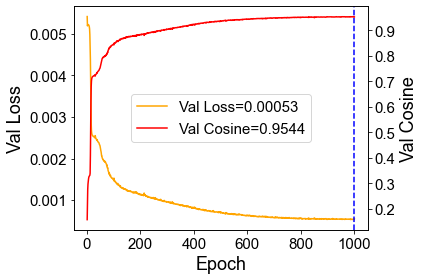

In [13]:
deepspec.ValPlot()
plt.savefig('../figure/DeepSpec.pdf')

In [14]:
# deepspec trian information
deepspec.traininfor.keys()
# deepspec.traininfor['val_losses']
# deepspec.traininfor['val_cosines']
# [ i.mean() for i in deepspec.traininfor['val_cosines']]

dict_keys(['val_losses', 'val_cosines'])

In [15]:
%%time
# deepspec = DeepSpec()  
# If the current folder has DeepSpec saved, it is loaded by default
dfSP = deepspec.predict(dfRT, msms)

after filter none Intensities data shape: (202436, 4)
+++++++++++++++++++Loading Testset+++++++++++++++++++++
++++++++++++++++OneHotEncoder CMS(Chage + Modified sequence)++++++++++++++
using time 2.8118927478790283
x shape:  (202436, 48, 30)
++++++++++++++++++++++++++Construct Ion Intensities Array++++++++++++++++++++
using time 49.9742226600647
y shape:  (202436, 46, 12)
+++++++++++++++++++DeepSpec Testing+++++++++++++++++++++
Wall time: 2min 13s


In [16]:
# deepspec sampleset predicted information
deepspec.db_test.keys()

dict_keys(['Data', 'x_test', 'y_test', 'y_testpred', 'Cosine'])

# LgbBayes

In [17]:
from DeepSCP import LgbBayes

In [18]:
dfdb = deepcopy(dfSP)
dfdb.shape

(205789, 125)

In [19]:
dfdb.label.value_counts()

1    157906
0     47883
Name: label, dtype: int64

In [20]:
%%time
feature_columns = ['Length', 'Acetyl (Protein N-term)', 'Oxidation (M)', 'Missed cleavages',
                   'Charge', 'm/z', 'Mass', 'Mass error [ppm]', 'Retention length', 'PEP',
                   'MS/MS scan number', 'Score', 'Delta score','PIF', 'Intensity',
                   'Retention time', 'RT(*|rev)', 'RT(*|tag)', 'DeltaRT', 'PEPRT', 'ScoreRT',
                   'Cosine','PEPCosine', 'ScoreCosine']
target_column='label'
file_column = 'Experiment'
protein_column = 'Leading razor protein'
lgs = LgbBayes()
data_set = lgs.fit_tranform(data=dfdb,
                                feature_columns=feature_columns,
                                target_column=target_column,
                                file_column=file_column,
                                protein_column=protein_column)

++++++++++++++++CV 1+++++++++++++++
train auc: 0.9238766020769839
test auc: 0.9379211200829646
++++++++++++++++CV 2+++++++++++++++
train auc: 0.9289381179380496
test auc: 0.9427248004833573
++++++++++++++++CV 3+++++++++++++++
train auc: 0.9272802106480809
test auc: 0.9412275184131702
Wall time: 10min 1s


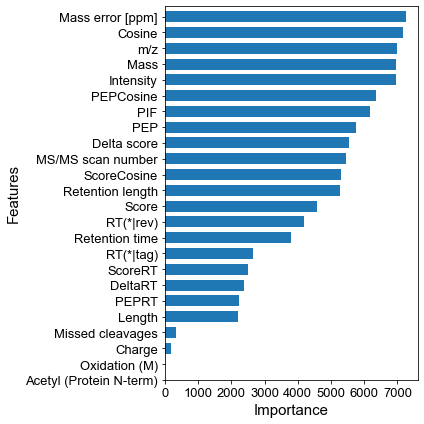

In [21]:
# feature importance
feature_imp = lgs.feature_imp
feature_imp.to_csv('../data/feature_imp.csv', index=None)
lgs.Feature_imp_plot()
plt.savefig('../figure/Feature_imp.pdf')

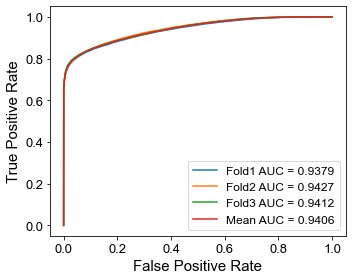

In [22]:
lgs.CVROC()
plt.savefig('../figure/DeepSCP_ROC.pdf')

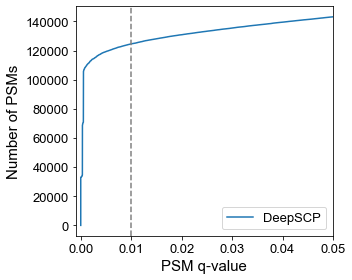

In [23]:
lgs.PSM_accept()
plt.savefig('../figure/PSM_accept.pdf')

# Peptide & Protein assembly

In [25]:
# PSM
data = data_set[(data_set.psm_qvalue < 0.01) & (data_set.protein_qvalue <0.01) &
              (data_set.label == 1)]
data.shape

(116052, 130)

In [26]:
# Peptide
data.Sequence.unique().shape

(18467,)

In [27]:
# Protein
data['Leading razor protein'].unique().shape

(4605,)

In [28]:
from DeepSCP import PSM2ProPep

In [29]:
from DeepSCP import showcols
showcols(data)

,1,2,3,4,5,6,7,8,9,10
0,Sequence,Length,Modifications,Modified sequence,Oxidation (M) Probabilities,Oxidation (M) Score Diffs,Acetyl (Protein N-term),Oxidation (M),Missed cleavages,Proteins
1,Leading proteins,Leading razor protein,Gene names,Protein names,Type,Raw file,Experiment,MS/MS m/z,Charge,m/z
2,Mass,Resolution,Uncalibrated - Calibrated m/z [ppm],Uncalibrated - Calibrated m/z [Da],Mass error [ppm],Mass error [Da],Uncalibrated mass error [ppm],Uncalibrated mass error [Da],Max intensity m/z 0,Retention time
3,Retention length,Calibrated retention time,Calibrated retention time start,Calibrated retention time finish,Retention time calibration,Match time difference,Match m/z difference,Match q-value,Match score,Number of data points
4,Number of scans,Number of isotopic peaks,PIF,Fraction of total spectrum,Base peak fraction,PEP,MS/MS count,MS/MS scan number,Score,Delta score
5,Combinatorics,Intensity,Reporter intensity corrected 1,Reporter intensity corrected 2,Reporter intensity corrected 3,Reporter intensity corrected 4,Reporter intensity corrected 5,Reporter intensity corrected 6,Reporter intensity corrected 7,Reporter intensity corrected 8
6,Reporter intensity corrected 9,Reporter intensity corrected 10,Reporter intensity corrected 11,Reporter intensity corrected 12,Reporter intensity corrected 13,Reporter intensity corrected 14,Reporter intensity corrected 15,Reporter intensity corrected 16,Reporter intensity 1,Reporter intensity 2
7,Reporter intensity 3,Reporter intensity 4,Reporter intensity 5,Reporter intensity 6,Reporter intensity 7,Reporter intensity 8,Reporter intensity 9,Reporter intensity 10,Reporter intensity 11,Reporter intensity 12
8,Reporter intensity 13,Reporter intensity 14,Reporter intensity 15,Reporter intensity 16,Reporter intensity count 1,Reporter intensity count 2,Reporter intensity count 3,Reporter intensity count 4,Reporter intensity count 5,Reporter intensity count 6
9,Reporter intensity count 7,Reporter intensity count 8,Reporter intensity count 9,Reporter intensity count 10,Reporter intensity count 11,Reporter intensity count 12,Reporter intensity count 13,Reporter intensity count 14,Reporter intensity count 15,Reporter intensity count 16


In [30]:
file_column = 'Experiment'
protein_column = 'Leading razor protein'
peptide_column = 'Sequence'
intensity_columns = [i for i in data.columns if 'Reporter intensity corrected' in i]

df_pro, df_pep = PSM2ProPep(data, file_column=file_column,
                           protein_column=protein_column,
                           peptide_column=peptide_column,
                           intensity_columns=intensity_columns)

In [31]:
intensity_columns

['Reporter intensity corrected 1',
 'Reporter intensity corrected 2',
 'Reporter intensity corrected 3',
 'Reporter intensity corrected 4',
 'Reporter intensity corrected 5',
 'Reporter intensity corrected 6',
 'Reporter intensity corrected 7',
 'Reporter intensity corrected 8',
 'Reporter intensity corrected 9',
 'Reporter intensity corrected 10',
 'Reporter intensity corrected 11',
 'Reporter intensity corrected 12',
 'Reporter intensity corrected 13',
 'Reporter intensity corrected 14',
 'Reporter intensity corrected 15',
 'Reporter intensity corrected 16']

In [32]:
df_pep.shape

(18467, 194)

In [33]:
df_pro.shape

(4605, 192)

In [34]:
df_pep.head()

,Leading razor protein,Sequence,B1_Reporter intensity corrected 1,B1_Reporter intensity corrected 2,B1_Reporter intensity corrected 3,B1_Reporter intensity corrected 4,B1_Reporter intensity corrected 5,B1_Reporter intensity corrected 6,B1_Reporter intensity corrected 7,B1_Reporter intensity corrected 8,...,C9_Reporter intensity corrected 7,C9_Reporter intensity corrected 8,C9_Reporter intensity corrected 9,C9_Reporter intensity corrected 10,C9_Reporter intensity corrected 11,C9_Reporter intensity corrected 12,C9_Reporter intensity corrected 13,C9_Reporter intensity corrected 14,C9_Reporter intensity corrected 15,C9_Reporter intensity corrected 16
0,A0A023T778,FGHEFLEFEFRPDGK,124720.0,8273.3,8797.3,1001.3,225.19,0.0,0.0,835.87,...,0.0,1024.1,0.00,735.46,467.60,0.00,0.00,2215.1,446.74,846.85
1,A0A023T778,IGSLIDVNQSK,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
2,A0A023T778,IIDDSEITK,156570.0,6841.6,3337.4,0.0,0.00,0.0,0.0,1049.50,...,0.0,1437.1,667.52,1224.50,774.64,781.94,818.39,3082.2,1176.80,867.42
3,A0A023T778,VFYYLVQDLK,94462.0,5228.0,5632.5,0.0,0.00,0.0,0.0,862.67,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00
4,A0A023T778,YANNSNYK,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [35]:
df_pro.head()

,B1_Reporter intensity corrected 1,B1_Reporter intensity corrected 2,B1_Reporter intensity corrected 3,B1_Reporter intensity corrected 4,B1_Reporter intensity corrected 5,B1_Reporter intensity corrected 6,B1_Reporter intensity corrected 7,B1_Reporter intensity corrected 8,B1_Reporter intensity corrected 9,B1_Reporter intensity corrected 10,...,C9_Reporter intensity corrected 7,C9_Reporter intensity corrected 8,C9_Reporter intensity corrected 9,C9_Reporter intensity corrected 10,C9_Reporter intensity corrected 11,C9_Reporter intensity corrected 12,C9_Reporter intensity corrected 13,C9_Reporter intensity corrected 14,C9_Reporter intensity corrected 15,C9_Reporter intensity corrected 16
Leading razor protein,,,,,,,,,,,,,,,,,,,,,
A0A023T778,375752.0,20342.9,17767.2,1001.3,225.19,0.00,0.0,2748.04,814.89,3939.89,...,0.0,2461.2,667.52,1959.96,1242.24,781.94,818.39,5297.3,1623.54,1714.27
A0A087WNT1,420030.0,26775.0,47514.0,2142.2,1309.00,410.68,0.0,4375.00,970.43,4850.60,...,0.0,11802.0,3030.32,7448.40,7164.20,4095.99,3850.06,18575.2,3528.75,6927.34
A0A087WNV1,16133.0,1047.8,1121.6,0.0,0.00,0.00,0.0,919.42,306.10,575.28,...,0.0,1321.3,0.00,506.38,272.00,632.00,0.00,1201.0,498.92,426.60
A0A087WPE4,83116.0,1328.7,1873.1,0.0,0.00,0.00,0.0,10456.00,957.68,7184.40,...,0.0,12110.0,1566.50,6152.10,6275.10,1414.80,3088.10,30862.0,2055.10,4611.90
A0A087WPT7,109635.0,5293.8,5449.0,0.0,285.44,0.00,0.0,3802.96,1208.28,3317.15,...,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00


In [36]:
data_set.to_csv('../data/DeepSCP_evidence.txt', sep='\t', index=False)
data.to_csv('../data/DeepSCP_evidence_filter.txt', sep='\t', index=False)
df_pro.to_csv('../data/DeepSCP_pro.csv')
df_pep.to_csv('../data/DeepSCP_pep.csv')

In [47]:
data.to_csv('../data/DeepSCP_evidence_filter.txt', sep='\t', index=False)

# Protein filter

In [37]:
from DeepSCP import proteinfilter

In [38]:
an_cols = pd.DataFrame({'Sample_id':  df_pro.columns,
                        'Set': [i.rsplit('_', 1)[0] for i in df_pro.columns],
                       'Channel': [i.rsplit('_', 1)[-1] for i in df_pro.columns]})

an_cols['Type'] = 'Empty'
an_cols.loc[an_cols.Channel =='Reporter intensity corrected 1', 'Type'] = 'Boost'
an_cols.loc[an_cols.Channel =='Reporter intensity corrected 2' 'Type'] = 'Reference'

an_cols.loc[an_cols.Channel.isin(['Reporter intensity corrected 8',
                                  'Reporter intensity corrected 11',
                                  'Reporter intensity corrected 14']), 'Type'] = 'C10'
an_cols.loc[an_cols.Channel.isin(['Reporter intensity corrected 9',
                                  'Reporter intensity corrected 12',
                                  'Reporter intensity corrected 15']), 'Type'] = 'RAW'
an_cols.loc[an_cols.Channel.isin(['Reporter intensity corrected 10',
                                  'Reporter intensity corrected 13',
                                  'Reporter intensity corrected 16']), 'Type'] = 'SVEC'
an_cols.to_csv('../data/an_cols.csv', index=False)
an_cols1 = an_cols[(an_cols.Type.isin(['C10', 'SVEC', 'RAW']))]
an_cols1.Type.value_counts()

C10     36
SVEC    36
RAW     36
Name: Type, dtype: int64

In [39]:
an_cols1.head()

,Sample_id,Set,Channel,Type
7,B1_Reporter intensity corrected 8,B1,Reporter intensity corrected 8,C10
8,B1_Reporter intensity corrected 9,B1,Reporter intensity corrected 9,RAW
9,B1_Reporter intensity corrected 10,B1,Reporter intensity corrected 10,SVEC
10,B1_Reporter intensity corrected 11,B1,Reporter intensity corrected 11,C10
11,B1_Reporter intensity corrected 12,B1,Reporter intensity corrected 12,RAW


In [40]:
df_pro1 = df_pro[set(df_pro.columns) & set(an_cols1.Sample_id)]
df_pro1.shape

(4605, 108)

In [41]:
df_pep1 = df_pep[[protein_column] + [peptide_column]  + df_pro1.columns.tolist()]
df_pep1.shape

(18467, 110)

In [42]:
# filter all proteins number
# df_pro_ft= proteinfilter(df_pro1,protein_count=15, sample_ratio=0.5)
df_pro_ft= proteinfilter(df_pro1)
df_pro_ft.shape

(3448, 108)

In [43]:
# filter all peptide number
df_pep_ft = df_pep1[df_pep1[protein_column].isin(df_pro_ft.index)]
df_pep_ft.shape

(17242, 110)

In [44]:
# filter mean proteins number
(df_pro_ft!=0).sum(0).mean()

2239.509259259259

In [45]:
# filter mean peptides number
(df_pep_ft.iloc[:,2:] != 0).sum(0).mean()

8653.166666666666

In [46]:
df_pro_ft.to_csv('../data/DeepSCP_pro_ft.csv')
df_pep_ft.to_csv('../data/DeepSCP_pep_ft.csv')